# 05_Model_Ensemble_Comparison
Compare saved models: Random Forest, OCSVM, Isolation Forest, and soft-voting Ensemble

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from scipy.sparse import hstack
import seaborn as sns
import matplotlib.pyplot as plt
import joblib


In [10]:
# Load data
df = pd.read_csv('../models/final_balanced_train.csv')
print("Columns:", df.columns.tolist())
X = df.drop('fraudulent', axis=1)
y = df['fraudulent']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

Columns: ['title', 'location', 'department', 'salary_range', 'telecommuting', 'has_company_logo', 'has_questions', 'employment_type', 'required_experience', 'required_education', 'industry', 'function', 'fraudulent', 'description_cleaned', 'description_word_count', 'requirements_cleaned', 'requirements_word_count', 'benefits_cleaned', 'benefits_word_count', 'company_profile_cleaned', 'company_profile_word_count', 'salary_min', 'salary_max', 'salary_avg', 'location_is_missing', 'department_is_missing', 'salary_range_is_missing', 'company_profile_is_missing', 'description_is_missing', 'requirements_is_missing', 'benefits_is_missing', 'employment_type_is_missing', 'required_experience_is_missing', 'required_education_is_missing', 'industry_is_missing', 'function_is_missing', 'salary_min_is_missing', 'salary_max_is_missing', 'salary_avg_is_missing', 'title_suspicious_count', 'company_info_score']


In [12]:
# Suspicious keyword flag
suspicious_keywords = r"(money|earn|transfer|urgent|wire|click here|quick cash|work from home|guarantee|easy|no skills|required|start immediately|instant payments|limited spots|flexible hours|sign up now|\$\d+|act now)"
df['has_suspicious_terms'] = df['description_cleaned'].fillna('').str.contains(
    suspicious_keywords, case=False, regex=True
).astype(int)


C:\Users\arpit\AppData\Local\Temp\ipykernel_16432\816504862.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['has_suspicious_terms'] = df['description_cleaned'].fillna('').str.contains(


In [14]:
# Split
X_text = df['description_cleaned']
X_meta = df[['has_suspicious_terms']]
y = df['fraudulent']

X_train_text, X_test_text, X_train_meta, X_test_meta, y_train, y_test = train_test_split(
    X_text, X_meta, y, test_size=0.2, stratify=y, random_state=42
)
# Ensure text data has no NaN values
X_train_text = X_train_text.fillna("")
X_test_text = X_test_text.fillna("")

# TF-IDF
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
X_train_vec = tfidf.fit_transform(X_train_text)
X_test_vec = tfidf.transform(X_test_text)

# Combine
X_train_combined = hstack([X_train_vec, X_train_meta])
X_test_combined = hstack([X_test_vec, X_test_meta])


In [18]:
# Base models
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
lr = LogisticRegression(max_iter=500, class_weight='balanced')
nb = MultinomialNB()

# Ensemble
ensemble = VotingClassifier(estimators=[
    ('rf', rf),
    ('lr', lr),
    ('nb', nb)
], voting='soft')

# Fit
ensemble.fit(X_train_combined, y_train)

# Predict
ensemble_preds = ensemble.predict(X_test_combined)


In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{title} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

# Fit base models individually
rf.fit(X_train_combined, y_train)
lr.fit(X_train_combined, y_train)
nb.fit(X_train_combined, y_train)

# Predict
rf_preds = rf.predict(X_test_combined)
lr_preds = lr.predict(X_test_combined)
nb_preds = nb.predict(X_test_combined)


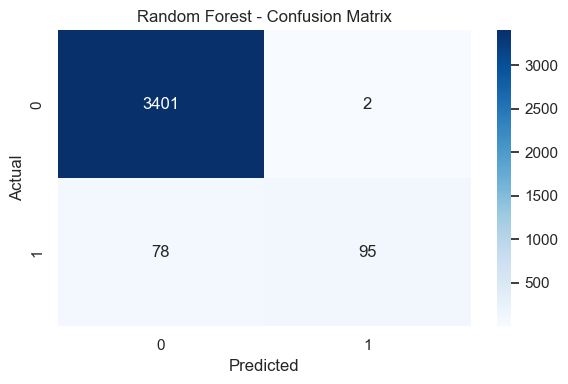

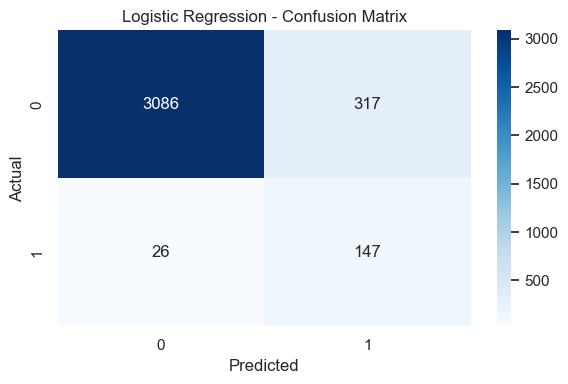

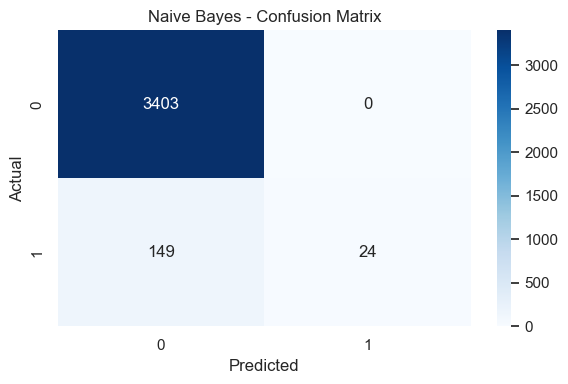

In [28]:
plot_confusion(y_test, rf_preds, "Random Forest")
plot_confusion(y_test, lr_preds, "Logistic Regression")
plot_confusion(y_test, nb_preds, "Naive Bayes")


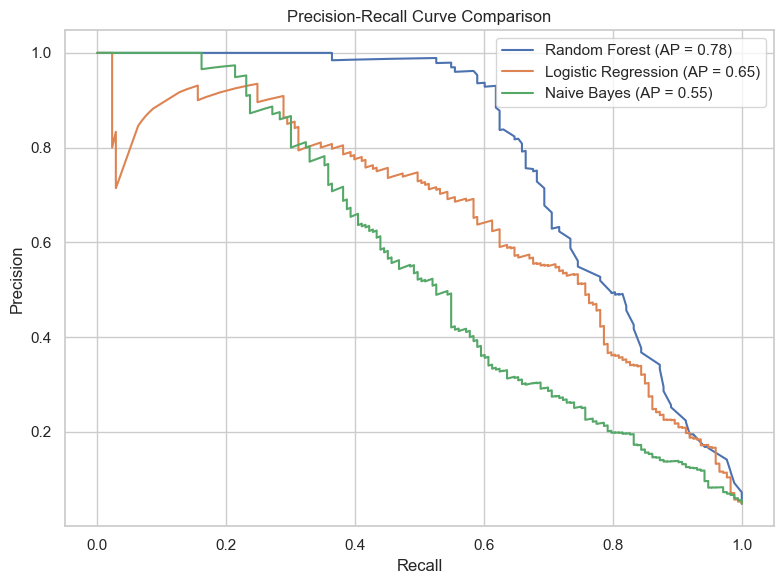

In [31]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_precision_recall(y_true, y_probs, label):
    precision, recall, _ = precision_recall_curve(y_true, y_probs)
    ap = average_precision_score(y_true, y_probs)
    plt.plot(recall, precision, label=f'{label} (AP = {ap:.2f})')

plt.figure(figsize=(8, 6))
plot_precision_recall(y_test, rf.predict_proba(X_test_combined)[:,1], 'Random Forest')
plot_precision_recall(y_test, lr.predict_proba(X_test_combined)[:,1], 'Logistic Regression')
plot_precision_recall(y_test, nb.predict_proba(X_test_combined)[:,1], 'Naive Bayes')
plt.title("Precision-Recall Curve Comparison")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.tight_layout()
plt.show()


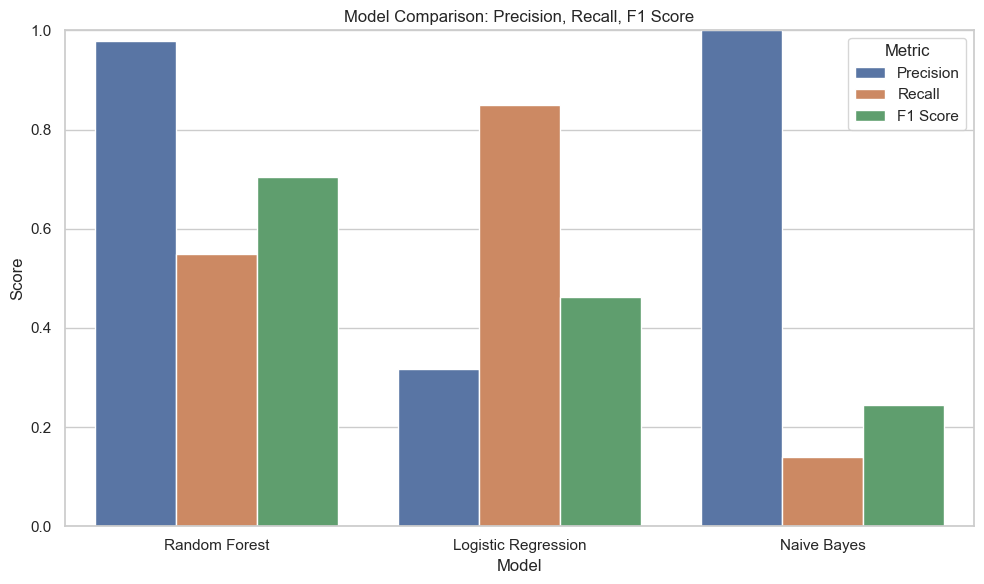

In [32]:
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate metrics for each model
metrics = {
    'Model': ['Random Forest', 'Logistic Regression', 'Naive Bayes'],
    'Precision': [
        precision_score(y_test, rf_preds),
        precision_score(y_test, lr_preds),
        precision_score(y_test, nb_preds)
    ],
    'Recall': [
        recall_score(y_test, rf_preds),
        recall_score(y_test, lr_preds),
        recall_score(y_test, nb_preds)
    ],
    'F1 Score': [
        f1_score(y_test, rf_preds),
        f1_score(y_test, lr_preds),
        f1_score(y_test, nb_preds)
    ]
}

# Convert to DataFrame
metrics_df = pd.DataFrame(metrics)

# Melt for seaborn
metrics_melted = metrics_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_melted, x='Model', y='Score', hue='Metric')
plt.title('Model Comparison: Precision, Recall, F1 Score')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


In [20]:
# Load saved models
ocsvm_model = joblib.load("../models/ocsvm_model.pkl")
if_model = joblib.load("../models/isolation_forest_model.pkl")
ocsvm_vectorizer = joblib.load("../models/ocsvm_vectorizer.pkl")
if_vectorizer = joblib.load("../models/isolation_forest_vectorizer.pkl")

# Transform for both
X_test_ocsvm = ocsvm_vectorizer.transform(X_test_text)
X_test_if = if_vectorizer.transform(X_test_text)

# Predict
ocsvm_preds = ocsvm_model.predict(X_test_ocsvm)
if_preds = if_model.predict(X_test_if)

# Convert -1 to 1 (fraud), 1 to 0 (real)
ocsvm_preds = np.where(ocsvm_preds == -1, 1, 0)
if_preds = np.where(if_preds == -1, 1, 0)


In [21]:
def majority_vote(rf, ocsvm, iforest, threshold=2):
    return ((rf + ocsvm + iforest) >= threshold).astype(int)

final_ensemble = majority_vote(ensemble_preds, ocsvm_preds, if_preds)


              Model  Accuracy  Precision    Recall  F1 Score
0  VotingClassifier  0.974832   0.977011  0.491329  0.653846
1             OCSVM  0.815436   0.054845  0.173410  0.083333
2   IsolationForest  0.931488   0.038462  0.017341  0.023904
3    HybridEnsemble  0.954978   0.875000  0.080925  0.148148


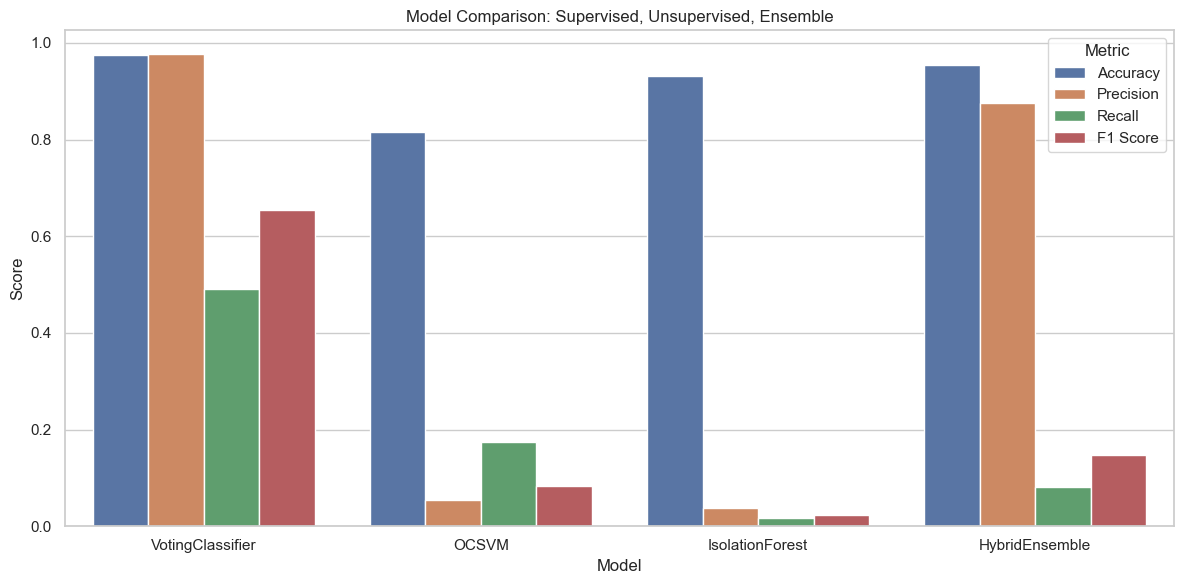

In [22]:
models = {
    'VotingClassifier': ensemble_preds,
    'OCSVM': ocsvm_preds,
    'IsolationForest': if_preds,
    'HybridEnsemble': final_ensemble
}

results = []
for name, preds in models.items():
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, preds),
        'Precision': precision_score(y_test, preds),
        'Recall': recall_score(y_test, preds),
        'F1 Score': f1_score(y_test, preds)
    })

results_df = pd.DataFrame(results)
print(results_df)

# Plot
sns.set(style="whitegrid")
melted = results_df.melt(id_vars='Model', var_name='Metric', value_name='Score')
plt.figure(figsize=(12, 6))
sns.barplot(data=melted, x='Model', y='Score', hue='Metric')
plt.title('Model Comparison: Supervised, Unsupervised, Ensemble')
plt.tight_layout()
plt.show()


In [24]:
joblib.dump(ensemble, "../models/voting_classifier_model.pkl")
joblib.dump(tfidf, "../models/ensemble_vectorizer.pkl")


['../models/ensemble_vectorizer.pkl']